# Evaluating the Operations Rehearsal for Commissioning simulated observing sequence

In [1]:
import pandas as pd
import numpy as np
from astropy.time import Time
import sqlite3

In [2]:
import lsst.daf.butler as dafButler
from lsst.pipe.tasks.loadReferenceCatalog import LoadReferenceCatalogConfig, LoadReferenceCatalogTask
from lsst.utils import getPackageDir
import lsst.geom

In [3]:
import matplotlib.pyplot as plt
%matplotlib widget

In [4]:
db = 'ops_rehearsal_apr_2024_v2.db'

In [5]:
conn = sqlite3.connect(db)

In [6]:
observations = pd.read_sql('select * from observations;', conn)

In [7]:
observations

observationId     fieldRA   fieldDec  observationStartMJD  \
0                  0  124.979911 -15.168900         60390.000796   
1                  1  124.981610 -15.134916         60390.001192   
2                  2  124.982461 -14.857953         60390.001592   
3                  3  124.914838 -15.128700         60390.001992   
4                  4  125.178891 -15.033544         60390.002391   
...              ...         ...        ...                  ...   
20123          20123  150.186883   2.102599         60410.998119   
20124          20124  150.196989   2.088532         60410.998514   
20125          20125  150.118036   2.208718         60410.998911   
20126          20126  150.093725   1.997420         60410.999310   
20127          20127  124.957075 -15.096293         60411.000472   

       flush_by_mjd  visitExposureTime filter   rotSkyPos  rotSkyPos_desired  \
0      60390.047222               30.0      r  137.325656                0.0   
1      60390.047222               30.0      r  138.032125                0.0   
2      60390.047222               30.0      r  138.729041                0.0   
3      60390.047222               30.0      r  138.609600                0.0   
4      60390.047222               30.0      r  138.579130                0.0   
...             ...                ...    ...         ...                ...   
20123  60411.019572               30.0      i  161.862310                0.0   
20124  60411.019572               30.0      i  162.001708                0.0   
20125  60411.019572               30.0      i  162.327130                0.0   
20126  60411.019572               30.0      i  162.379252                0.0   
20127  60411.046891               30.0      i  205.634146                0.0   

       numExposures  ...       sunAz      sunRA    sunDec      moonRA  \
0                 1  ...  261.144902   0.484833  0.209962  138.272165   
1                 1  ...  261.066980   0.485194  0.210118  138.275145   
2                 1  ...  260.988186   0.485558  0.210276  138.278153   
3                 1  ...  260.909334   0.485922  0.210434  138.281159   
4                 1  ...  260.830430   0.486286  0.210592  138.284161   
...             ...  ...         ...        ...       ...         ...   
20123             1  ...  268.164721  19.642990  8.290558   47.733828   
20124             1  ...  268.091682  19.643353  8.290703   47.739193   
20125             1  ...  268.018089  19.643719  8.290849   47.744598   
20126             1  ...  267.944151  19.644086  8.290996   47.750029   
20127             1  ...  267.728433  19.645154  8.291423   47.765874   

         moonDec  moonDistance  solarElong  moonPhase  cummTelAz  scripted_id  
0      21.734600     39.137859  123.199694  74.091535  49.226146            0  
1      21.733344     39.105123  123.206884  74.093006  49.166794            0  
2      21.732073     38.844141  123.254746  74.094492  48.662842            0  
3      21.730800     39.120750  123.143866  74.095977  49.020709            0  
4      21.729526     38.944865  123.411110  74.097460  49.378829            0  
...          ...           ...         ...        ...        ...          ...  
20123  21.820675    100.743771  129.606687  16.793129  48.270884            0  
20124  21.821813    100.753434  129.619226  16.795717  48.296469            0  
20125  21.822958    100.629172  129.515625  16.798323  48.088259            0  
20126  21.824106    100.683056  129.537459  16.800941  48.228318            0  
20127  21.827446     84.153356  106.849170  16.808580  -1.830305            0  

[20128 rows x 45 columns]

In [8]:
observations.columns

Index(['observationId', 'fieldRA', 'fieldDec', 'observationStartMJD',
       'flush_by_mjd', 'visitExposureTime', 'filter', 'rotSkyPos',
       'rotSkyPos_desired', 'numExposures', 'airmass', 'seeingFwhm500',
       'seeingFwhmEff', 'seeingFwhmGeom', 'skyBrightness', 'night', 'slewTime',
       'visitTime', 'slewDistance', 'fiveSigmaDepth', 'altitude', 'azimuth',
       'paraAngle', 'cloud', 'moonAlt', 'sunAlt', 'note', 'target', 'fieldId',
       'proposalId', 'block_id', 'observationStartLST', 'rotTelPos',
       'rotTelPos_backup', 'moonAz', 'sunAz', 'sunRA', 'sunDec', 'moonRA',
       'moonDec', 'moonDistance', 'solarElong', 'moonPhase', 'cummTelAz',
       'scripted_id'],
      dtype='object')

In [9]:
np.unique(observations['target'])

array(['COSMOS', 'DEEP_A0', 'DESI_SV3_R1', 'Rubin_SV_095_-25',
       'Rubin_SV_125_-15', 'Rubin_SV_225_-40', 'Rubin_SV_250_2',
       'Rubin_SV_280_-48', 'Rubin_SV_300_-41'], dtype=object)

In [117]:
min_moon_dist = 20. # deg
max_airmass = 2.0

assert np.all(observations['airmass'] < max_airmass)
assert np.all(np.degrees(observations['moonDistance']) > min_moon_dist)
assert np.all(observations['numExposures'] == 1)
assert np.all(observations['target'] == observations['note'])

In [10]:
# Note that can only set this date after downloading the full set sky brightness data
#mjd_start = Time('2024-04-01 00:00:00.000', format='iso').mjd
time_start = Time(np.min(observations['observationStartMJD']), format='mjd')
time_stop = Time(np.max(observations['observationStartMJD']), format='mjd')
print(time_start.iso)
print(time_stop.iso)

2024-03-21 00:01:08.817
2024-04-11 00:00:40.796


13
2024-04-02 23:30:16.536
2024-04-03 10:02:36.571


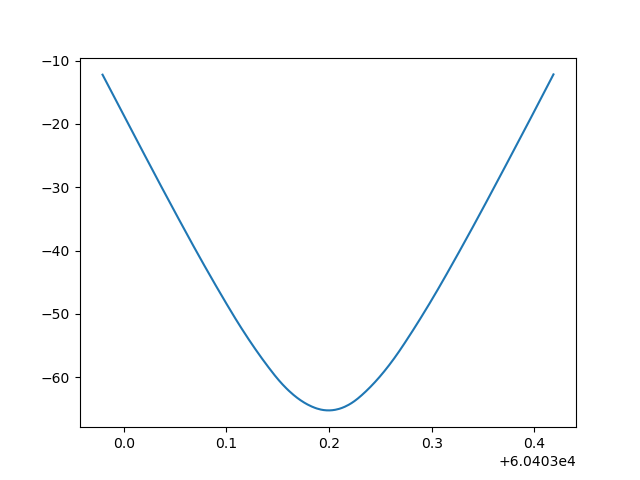

In [11]:
# Identify first night of the rehearsal
time_first = Time('2024-04-03 00:00:00.000', format='iso')
index_first = np.argmin(np.absolute(time_first.mjd - observations['observationStartMJD']))
#print(time_first.mjd)
#print(observations['mjd'][index_first])
night_first = observations['night'][index_first]
print(night_first)
selection = (observations['night'] == night_first)
print(
    Time(np.min(observations['observationStartMJD'][selection]), format='mjd').iso
)
print(
    Time(np.max(observations['observationStartMJD'][selection]), format='mjd').iso
)
plt.figure()
plt.plot(observations['observationStartMJD'][selection], observations['sunAlt'][selection])

## Visualize Single Field

In [12]:
for survey_name in np.unique(observations['target']):
    print(survey_name, np.sum(observations['target'] == survey_name))

COSMOS 2640
DEEP_A0 2580
DESI_SV3_R1 2400
Rubin_SV_095_-25 420
Rubin_SV_125_-15 2581
Rubin_SV_225_-40 3420
Rubin_SV_250_2 2160
Rubin_SV_280_-48 2729
Rubin_SV_300_-41 1198


In [13]:
survey_name = 'Rubin_SV_225_-40'
filter = 'r'

In [14]:
selection = (observations['target'] == survey_name) & (observations['filter'] == filter)
ra_boresight_array = observations['fieldRA'][selection]
dec_boresight_array = observations['fieldDec'][selection]
rotation_array = observations['rotSkyPos'][selection]

Text(0.5, 0.98, 'Telescope Boresight Pointings and Camera Rotation Angles')

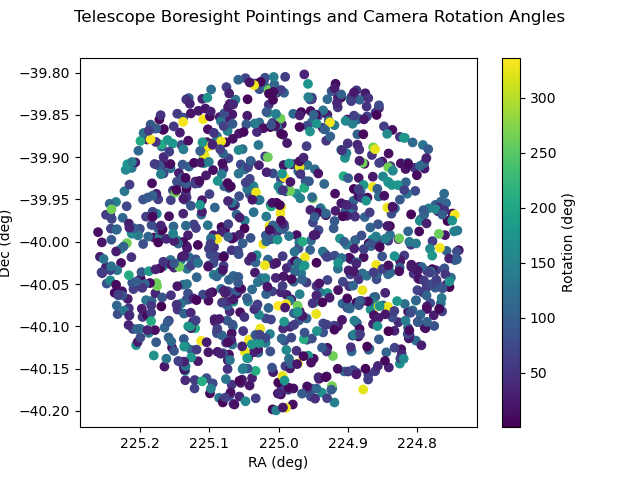

In [15]:
plt.figure()
plt.scatter(ra_boresight_array, dec_boresight_array, c=rotation_array)
plt.colorbar(label='Rotation (deg)')
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.suptitle('Telescope Boresight Pointings and Camera Rotation Angles')

(array([79., 94., 93., 64., 50., 27., 39., 97., 29., 58., 30., 51., 43.,
        77., 29., 55., 25., 40.,  0., 20., 12., 48.,  0.,  0.,  5., 15.,
         0.,  0.,  0.,  0.,  0.,  8., 12.,  0.,  0.,  0.,  0.,  0.,  0.,
        19., 21.]),
 array([  0.67202417,   8.86399039,  17.0559566 ,  25.24792281,
         33.43988902,  41.63185523,  49.82382144,  58.01578765,
         66.20775386,  74.39972007,  82.59168628,  90.78365249,
         98.97561871, 107.16758492, 115.35955113, 123.55151734,
        131.74348355, 139.93544976, 148.12741597, 156.31938218,
        164.51134839, 172.7033146 , 180.89528082, 189.08724703,
        197.27921324, 205.47117945, 213.66314566, 221.85511187,
        230.04707808, 238.23904429, 246.4310105 , 254.62297671,
        262.81494292, 271.00690914, 279.19887535, 287.39084156,
        295.58280777, 303.77477398, 311.96674019, 320.1587064 ,
        328.35067261, 336.54263882]),
 <BarContainer object of 41 artists>)

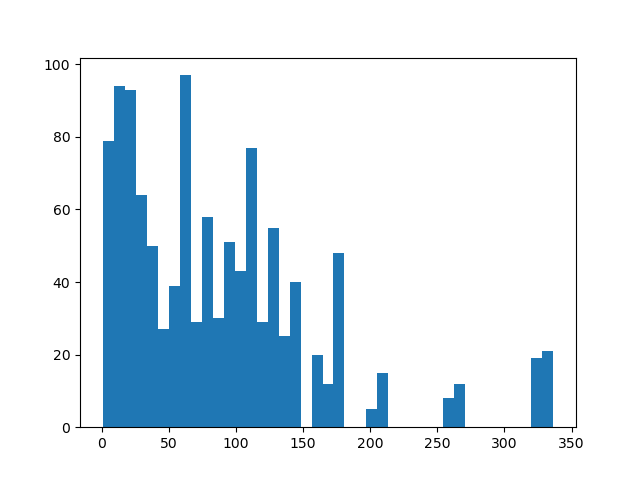

In [16]:
plt.figure()
plt.hist(rotation_array, bins=41)

## Visualize Single Field during Rehearsal Time Window

In [17]:
survey_name = 'Rubin_SV_225_-40'
filter = 'r'
nights_rehearsal = [night_first, night_first + 1, night_first + 2]

#selection = (observations['note'] == survey_name) & (observations['filter'] == filter) & (observations['night'] == night_first)
selection = (observations['target'] == survey_name) & (observations['filter'] == filter) & np.in1d(observations['night'], nights_rehearsal)
ra_boresight_array = observations['fieldRA'][selection]
dec_boresight_array = observations['fieldDec'][selection]
rotation_array = observations['rotSkyPos'][selection]

print(np.sum(selection))

200


Text(0.5, 0.98, 'Telescope Boresight Pointings and Camera Rotation Angles')

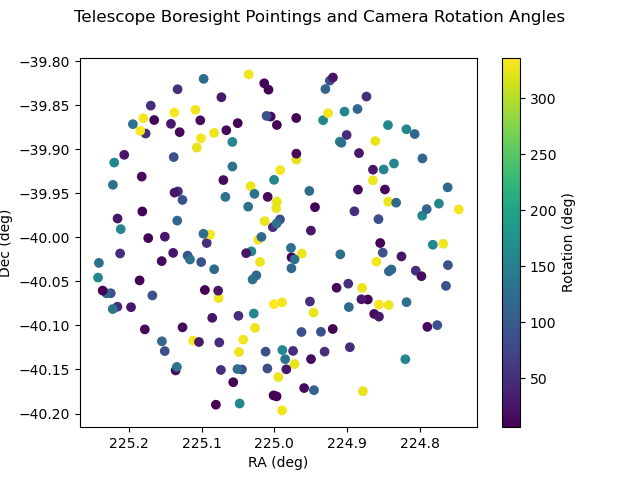

In [18]:
plt.figure()
plt.scatter(ra_boresight_array, dec_boresight_array, c=rotation_array)
plt.colorbar(label='Rotation (deg)')
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.suptitle('Telescope Boresight Pointings and Camera Rotation Angles')

## Visualize Survey

In [19]:
print(np.sum(observations['airmass'] > 2.0))
print(np.max(observations['airmass']))

0
1.9158962954599452


In [20]:
print(np.min(observations['moonDistance']))

21.017703194287925


In [21]:
np.unique(observations['target'])

array(['COSMOS', 'DEEP_A0', 'DESI_SV3_R1', 'Rubin_SV_095_-25',
       'Rubin_SV_125_-15', 'Rubin_SV_225_-40', 'Rubin_SV_250_2',
       'Rubin_SV_280_-48', 'Rubin_SV_300_-41'], dtype=object)

In [22]:
np.unique(observations['filter'])

array(['g', 'i', 'r'], dtype=object)

Text(0, 0.5, 'Altitude (degrees)')

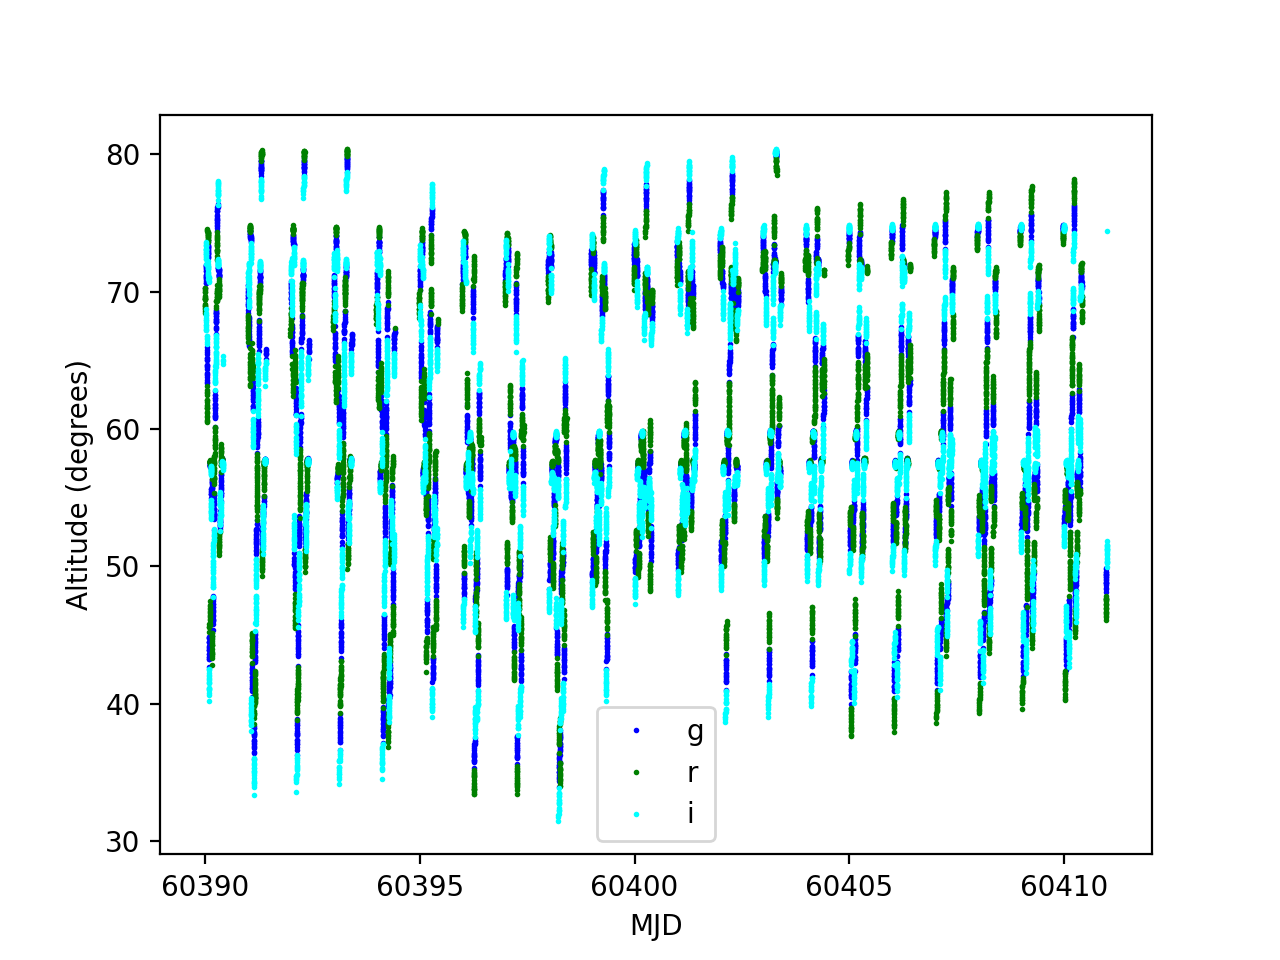

In [23]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['observationStartMJD'][in_filt], observations['altitude'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Altitude (degrees)')

Text(0, 0.5, 'Airmass')

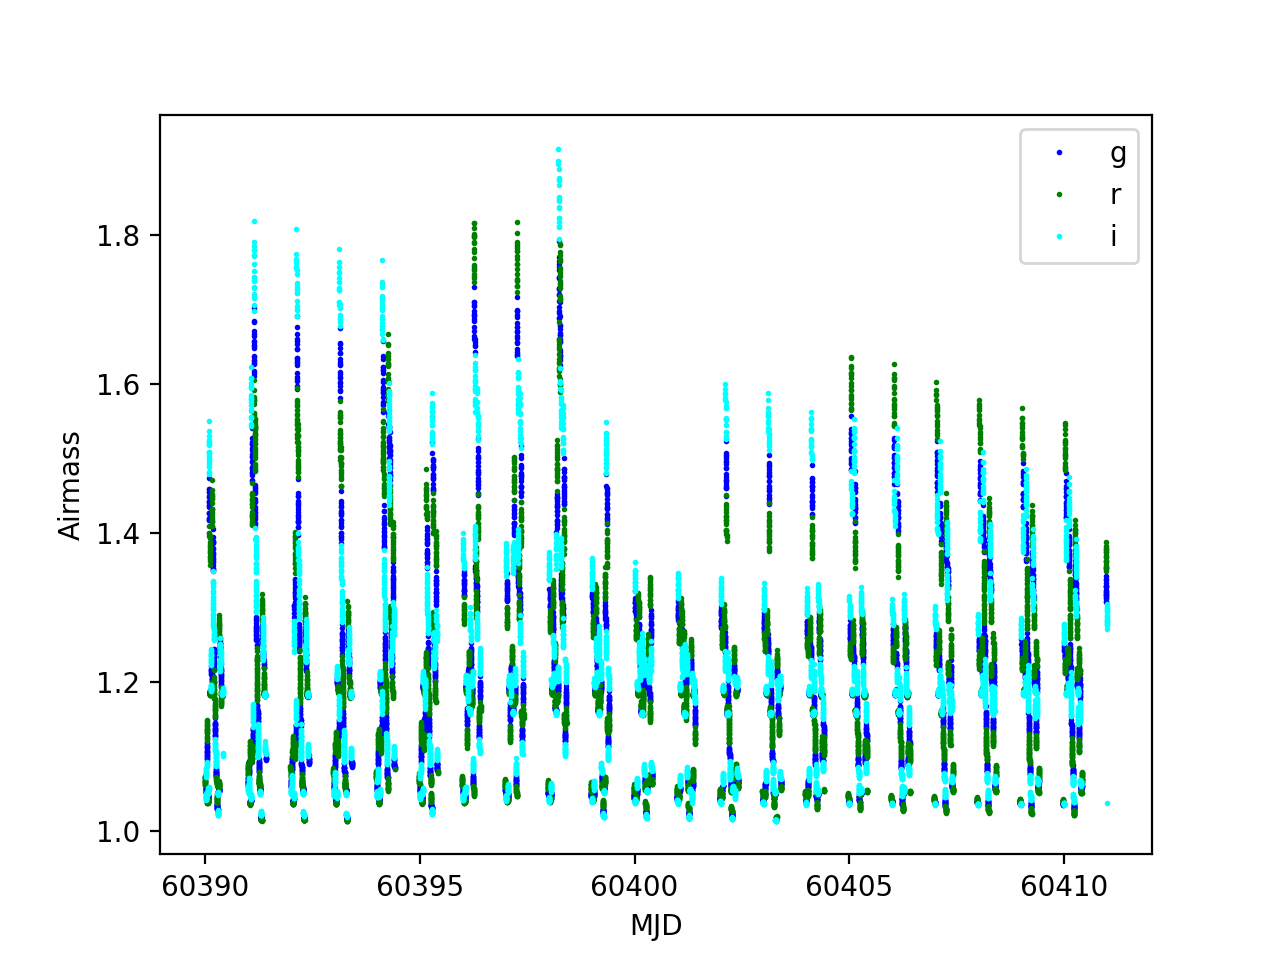

In [24]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['observationStartMJD'][in_filt], observations['airmass'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)
plt.legend()
plt.xlabel('MJD')
plt.ylabel('Airmass')

(60390.00079649804, 60390.22877504257)

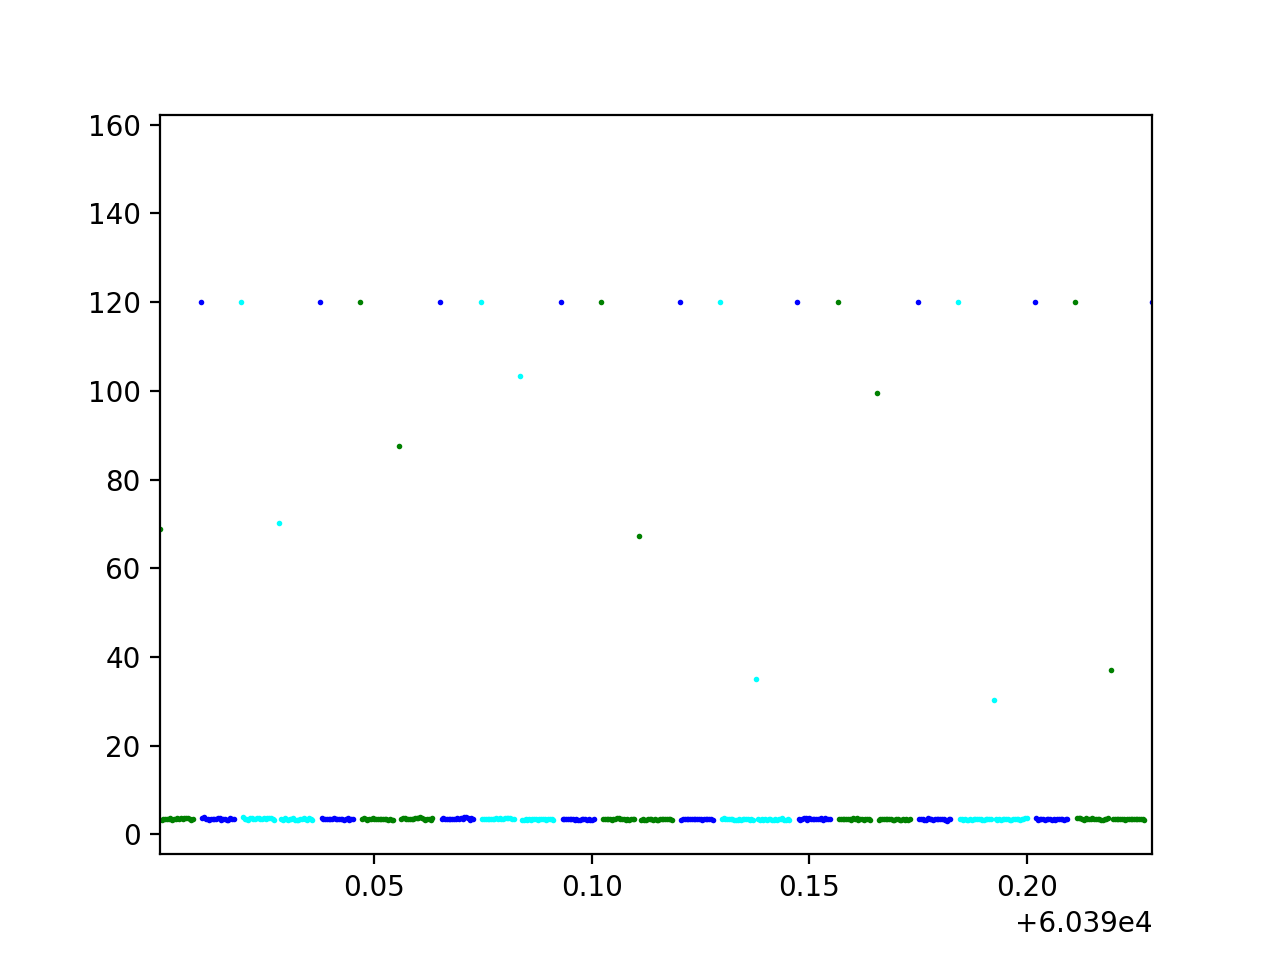

In [25]:
plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['observationStartMJD'][in_filt], observations['slewTime'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)
plt.xlim(observations['observationStartMJD'][0], observations['observationStartMJD'][500])

Text(0, 0.5, 'rotSkyPos')

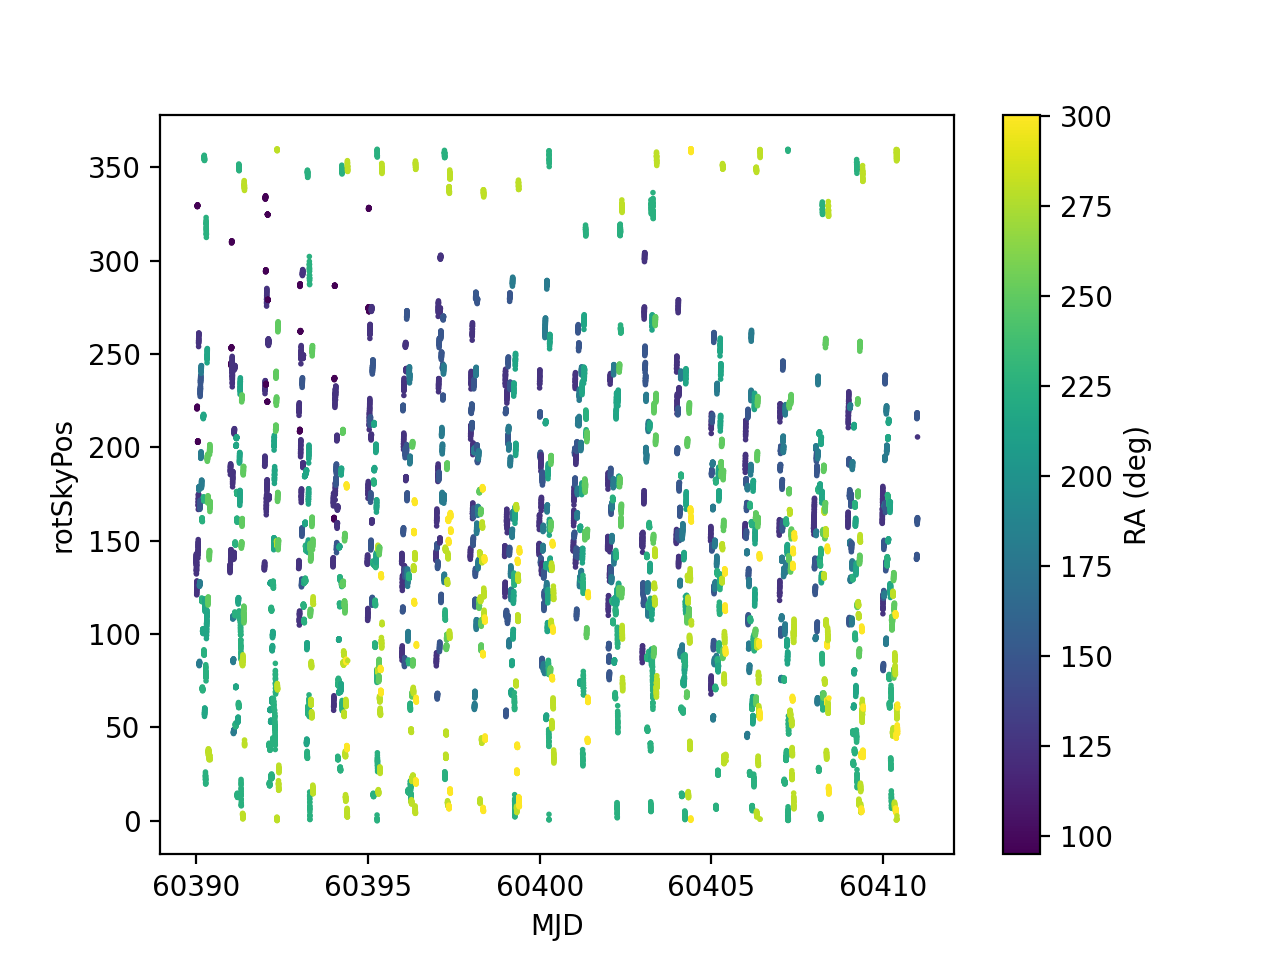

In [26]:
plt.figure(dpi=200)
plt.scatter(observations['observationStartMJD'], observations['rotSkyPos'], c=observations['fieldRA'], s=1)
plt.colorbar(label='RA (deg)')

plt.xlabel('MJD')
plt.ylabel('rotSkyPos')

(60390.00079649804, 60390.22877504257)

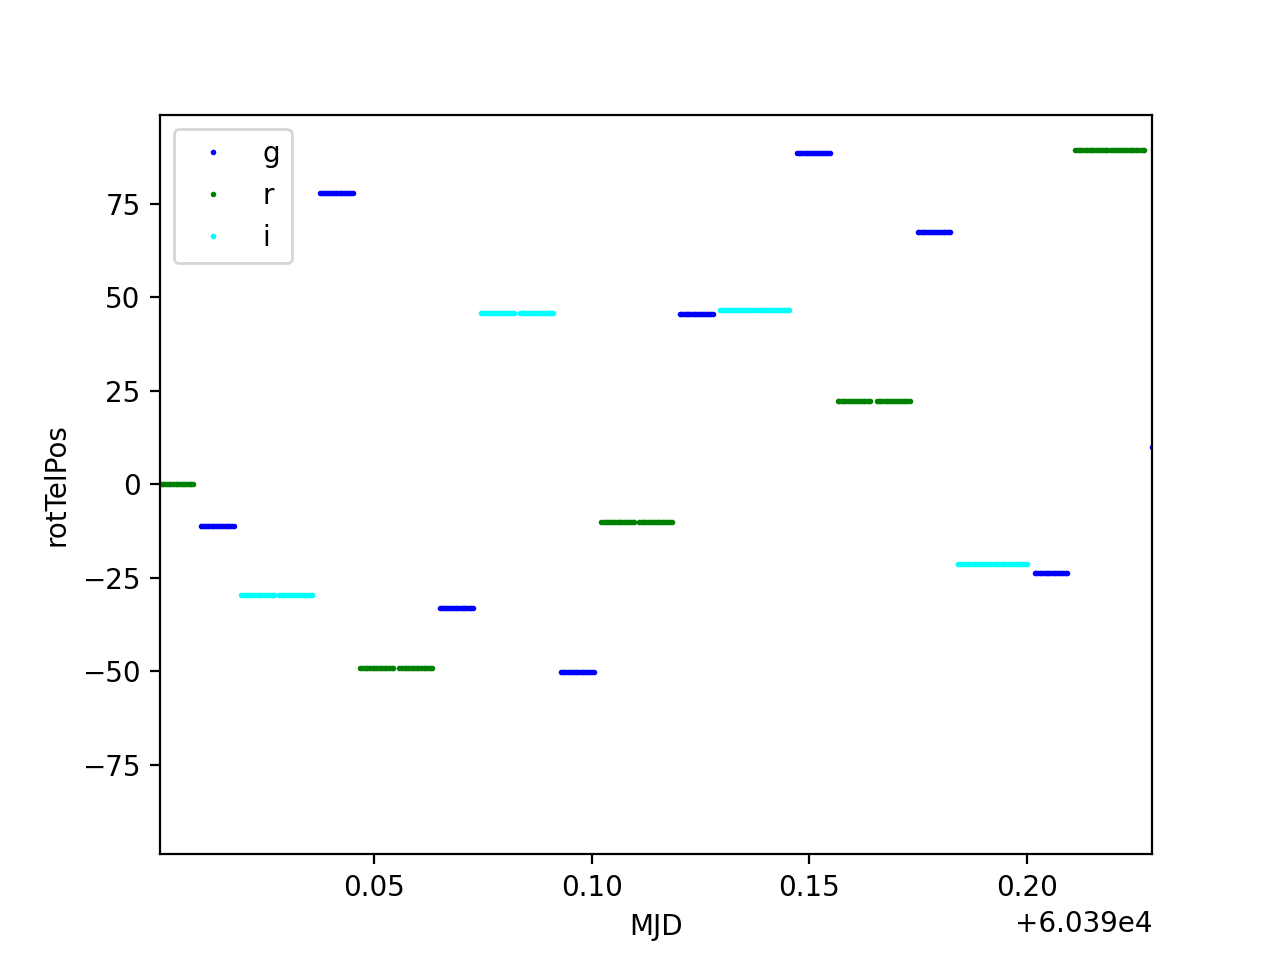

In [27]:
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}

plt.figure(dpi=200)
#plt.scatter(observations['observationStartMJD'], observations['rotTelPos'], c=observations['RA'], s=1)
#plt.colorbar(label='RA (deg)')

for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['observationStartMJD'][in_filt], observations['rotTelPos'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)
plt.legend()

plt.xlabel('MJD')
plt.ylabel('rotTelPos')
plt.xlim(observations['observationStartMJD'][0], observations['observationStartMJD'][500])

Text(0, 0.5, 'Airmass')

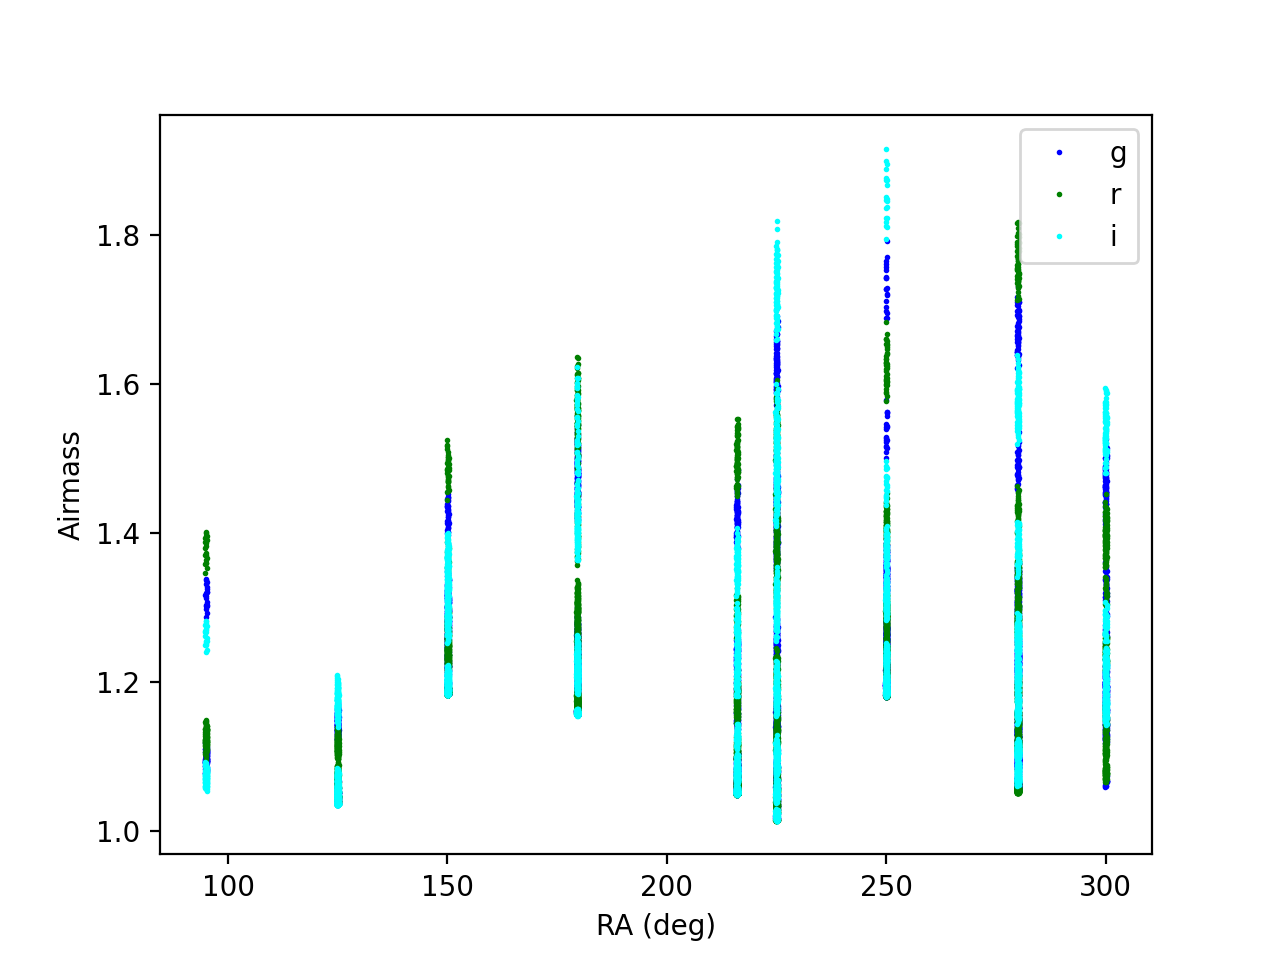

In [28]:
plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['fieldRA'][in_filt], observations['airmass'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)

plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('Airmass')

Text(0, 0.5, 'RA (deg)')

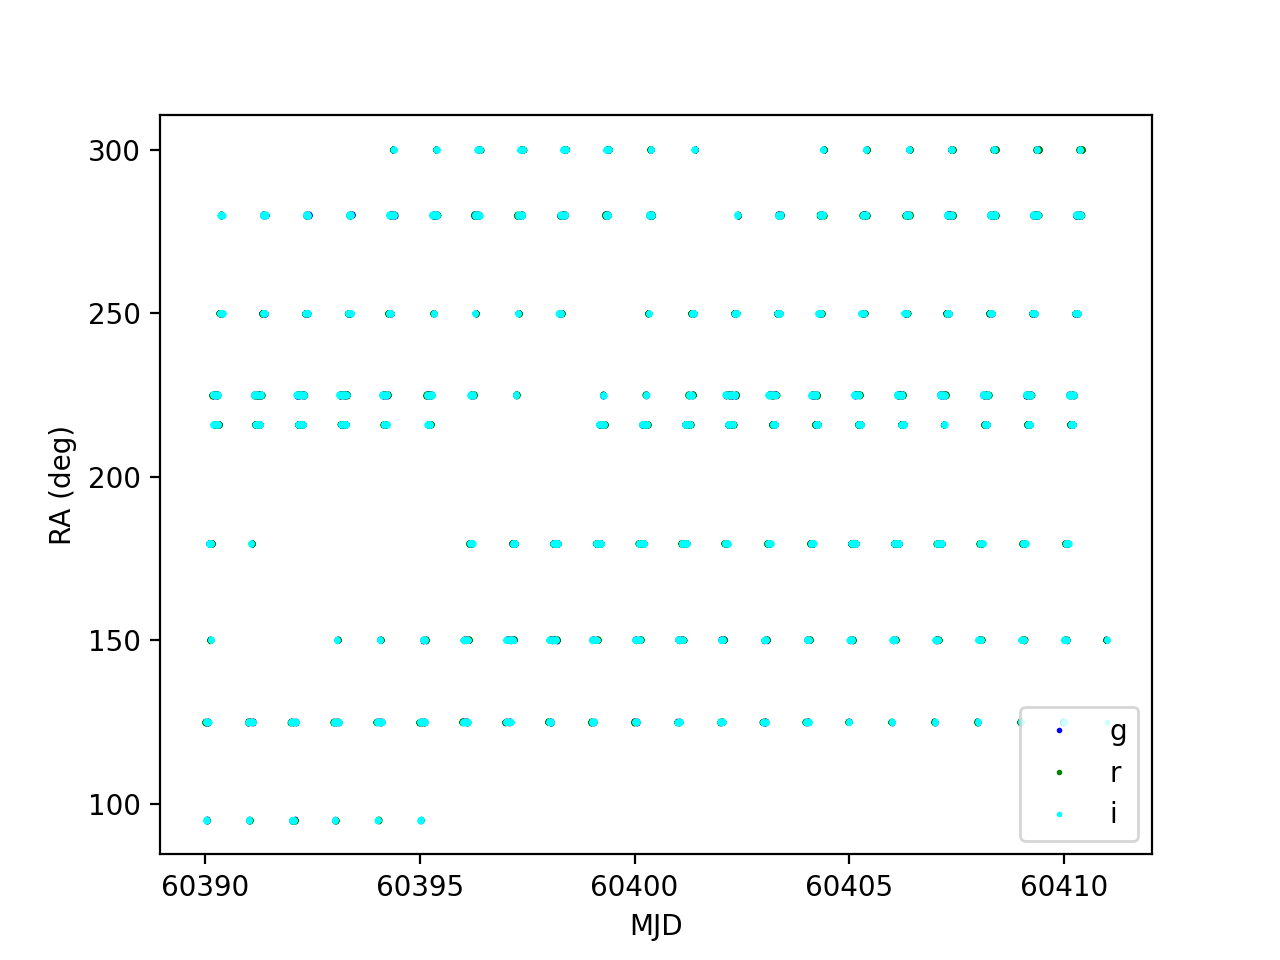

In [29]:
plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['observationStartMJD'][in_filt], observations['fieldRA'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)

plt.legend()
plt.xlabel('MJD')
plt.ylabel('RA (deg)')

Text(0, 0.5, 'moonDistance (deg)')

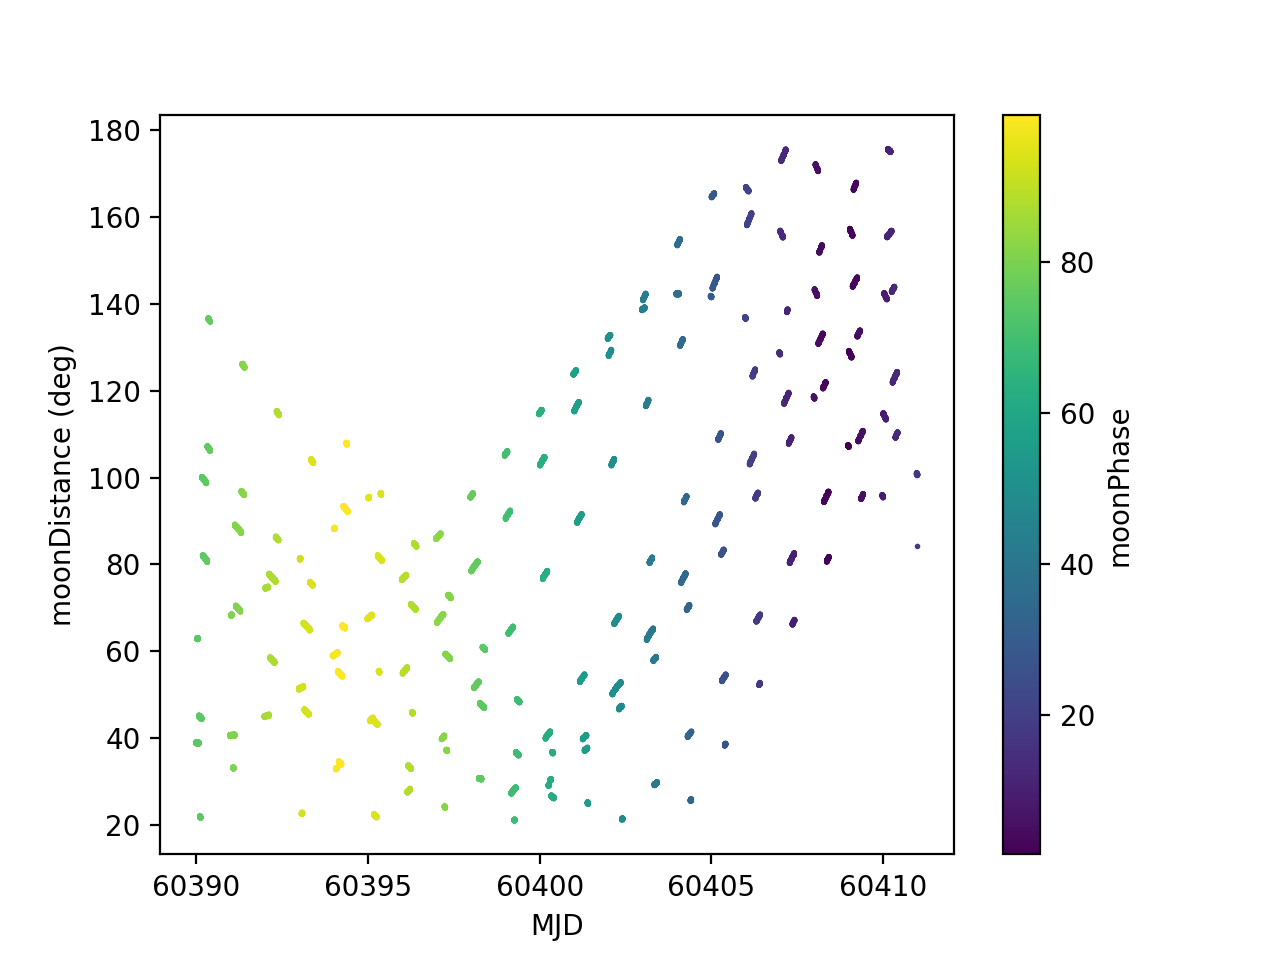

In [30]:
plt.figure(dpi=200)
#for filtername in f2c:
#    in_filt = np.where(observations['filter'] == filtername)[0]
#    if in_filt.size > 0:
#        plt.plot(observations['observationStartMJD'][in_filt], observations['moonDistance'][in_filt], 
#                 'o', markersize=1, color=f2c[filtername], label=filtername)

plt.scatter(observations['observationStartMJD'], observations['moonDistance'], c=observations['moonPhase'], s=1)
plt.colorbar(label='moonPhase')

#plt.legend()
plt.xlabel('MJD')
plt.ylabel('moonDistance (deg)')

Text(0, 0.5, 'rotSkyPos')

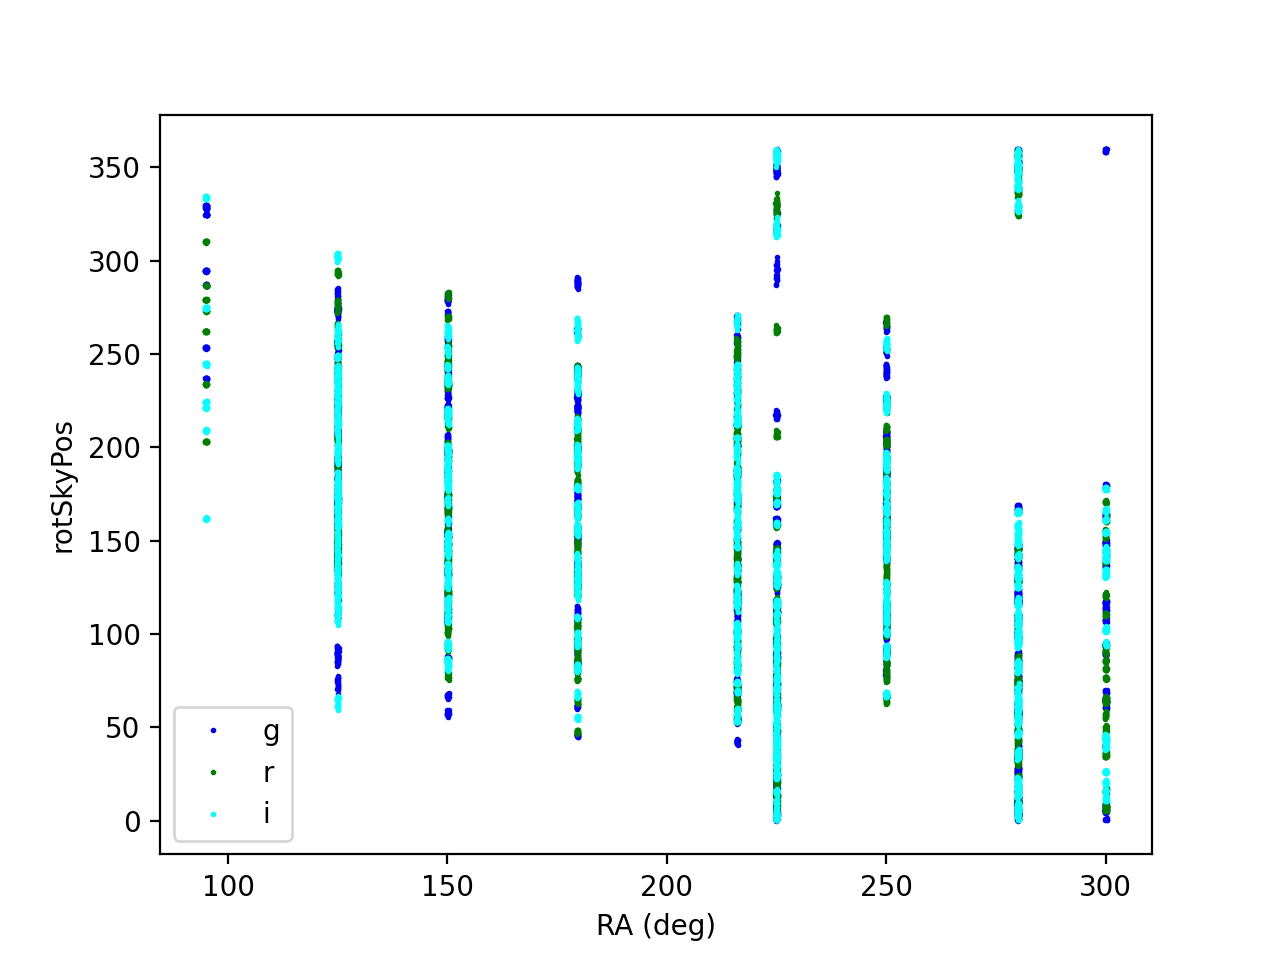

In [31]:
plt.figure(dpi=200)
for filtername in f2c:
    in_filt = np.where(observations['filter'] == filtername)[0]
    if in_filt.size > 0:
        plt.plot(observations['fieldRA'][in_filt], observations['rotSkyPos'][in_filt], 
                 'o', markersize=1, color=f2c[filtername], label=filtername)

plt.legend()
plt.xlabel('RA (deg)')
plt.ylabel('rotSkyPos')

49801.27933840267 60390.98958963024
49698.84455404244 60391.98871513576
49582.533101714216 60392.98784980551
49459.84407195356 60393.986985396055
49371.69894743711 60394.98612004508
49267.77482042089 60395.98526631023
49128.16905041691 60396.98440585628
49020.92561619356 60397.98355820821
48908.66628368385 60398.982706891824
48802.69989443477 60399.981865887145
48720.19109458197 60400.981020147316
48608.30277570058 60401.98019011409
48481.6783543909 60402.979358051685
48388.6507434072 60403.978532659814
48262.548903375864 60404.97771615686
48157.21482436638 60405.97689929633
48073.63054754678 60406.97609772449
47960.98624113947 60407.97529504953
47857.69977348391 60408.97449769641
47751.843568333425 60409.97370895495
47661.363826249726 60410.97313666594


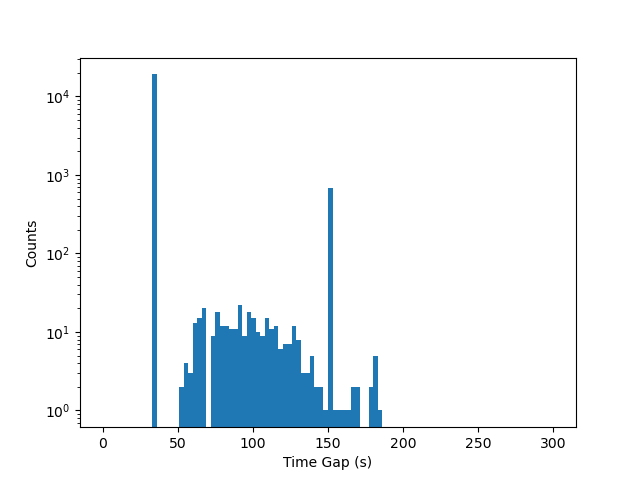

In [32]:
gap = (np.diff(observations['observationStartMJD']) * 24. * 3600.)

plt.figure()
plt.yscale('log')
bins = np.linspace(0., 300., 101)
plt.hist(gap, bins=bins)
plt.ylabel('Counts')
plt.xlabel('Time Gap (s)')

selection = gap > 300.
for index in np.nonzero(selection)[0]:
    print(gap[index], observations['observationStartMJD'][index + 1])

# Reference Catalog

In [33]:
# https://developer.lsst.io/usdf/storage.html#butler-access
repo = '/sdf/group/rubin/repo/main_20210215/'

In [34]:
config = os.path.join(repo, 'butler.yaml')
butler = dafButler.Butler(config=config)
registry = butler.registry

In [35]:
collection = 'refcats'
registry.getCollectionSummary(collection).dataset_types.names

dict_keys(['sdss_dr9_fink_v5b', 'ps1_pv3_3pi_20170110', 'gaia_dr2_20200414', 'atlas_refcat2_20220201', 'gaia_dr3_20230707'])

In [36]:
#refDataset = 'gaia_dr3'
refDataset = 'gaia_dr3_20230707'

In [37]:
ra_center = np.median(ra_boresight_array)
dec_center = np.median(dec_boresight_array)
print(ra_center, dec_center)

225.00360175255486 -40.007779437162405


In [38]:
# ra_center, dec_center = 180., -1.

In [39]:
import lsst.sphgeom

In [40]:
level = 7  # the resolution of the HTM grid
pixelization = lsst.sphgeom.HtmPixelization(level)

In [41]:
circle = lsst.sphgeom.Circle(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra_center, dec_center)
    ),
    lsst.sphgeom.Angle.fromDegrees(4.)
)

In [42]:
htm_set = np.concatenate([list(range(_[0], _[1])) for _ in pixelization.envelope(circle)]).tolist()

In [43]:
len(htm_set)

130

In [44]:
where_htm = "htm7 in (%s)"%(", ".join(str(_) for _ in htm_set))
print(where_htm)

htm7 in (179536, 179537, 179538, 179539, 179540, 179541, 179542, 179543, 179544, 179545, 179546, 179547, 179548, 179549, 179550, 179551, 179570, 179576, 179577, 179579, 179581, 179616, 179617, 179618, 179619, 179620, 179621, 179622, 179623, 179624, 179625, 179626, 179627, 179628, 179629, 179630, 179631, 179633, 179636, 179638, 179639, 179646, 179648, 179649, 179650, 179651, 179652, 179653, 179654, 179655, 179656, 179657, 179658, 179659, 179660, 179661, 179662, 179663, 179701, 179706, 179708, 180000, 180001, 180002, 180003, 180004, 180005, 180006, 180007, 180008, 180009, 180010, 180011, 180012, 180013, 180014, 180015, 180016, 180017, 180019, 180020, 180022, 180023, 180030, 180112, 180113, 180114, 180115, 180116, 180117, 180118, 180119, 180120, 180121, 180122, 180123, 180124, 180125, 180126, 180127, 180144, 180146, 180147, 180152, 180153, 180155, 180157, 180176, 180177, 180178, 180179, 180180, 180181, 180182, 180183, 180184, 180185, 180186, 180187, 180188, 180189, 180190, 180191, 180208,

In [45]:
datasetRefs = list(registry.queryDatasets(datasetType=refDataset, where=where_htm, collections=collection).expanded())

In [46]:
htm_id = pixelization.index(
    lsst.sphgeom.UnitVector3d(
        lsst.sphgeom.LonLat.fromDegrees(ra_center, dec_center)
    )
)
print(htm_id)

180176


In [47]:
circle = pixelization.triangle(htm_id).getBoundingCircle()
scale = circle.getOpeningAngle().asDegrees()*3600.
level = pixelization.getLevel()
print(f'HTM ID={htm_id} at level={level} is bounded by a circle of radius ~{scale:0.2f} arcsec.')

HTM ID=180176 at level=7 is bounded by a circle of radius ~2276.65 arcsec.


In [48]:
type(pixelization.triangle(htm_id).getBoundingCircle())

lsst.sphgeom._sphgeom.Circle

In [49]:
help(pixelization.index)

Help on method index in module lsst.sphgeom._sphgeom:

index(...) method of lsst.sphgeom._sphgeom.HtmPixelization instance
    index(self: lsst.sphgeom._sphgeom.Pixelization, i: lsst.sphgeom._sphgeom.UnitVector3d) -> int



In [50]:
# This is what I tried queryDatasets(..., collections="refcats", where=htm_where, findFirst=True), with htm_where="htm7 in (..list_of_shards..)"

In [51]:
# help(lsst.sphgeom.HtmPixelization)

Arbitrary regions aren't supported directly, but you can use something like "htm7 IN (A..B)" where I wrote "skymap='hsc_rings_v1' AND tract=9813" to do a query over lists of HTM IDs at some level, and lsst.sphgeom.Circle and lsst.sphgeom.HtmPixelization can be used to get those from a circle on the sky (happy to provide an example if that's what you want to do; also note that the C++ docs for these are decent, while the Python docs are nonexistent - but the interfaces are a straightforward translation).

In [52]:
config = LoadReferenceCatalogConfig()
config.refObjLoader.anyFilterMapsToThis = 'phot_g_mean'
config.doApplyColorTerms = False

In [53]:
# Alternative not recommended approach because only gets a single htm trixel
# datasetRefs = list(registry.queryDatasets(datasetType=refDataset, htm3=htm_id, collections=collection).expanded())

In [54]:
dataIds = [_.dataId for _ in datasetRefs]

In [55]:
refCats = [butler.getDeferred(refDataset, _, collections=['refcats']) for _ in dataIds]

In [56]:
loaderTask = LoadReferenceCatalogTask(config=config, name=refDataset, dataIds=dataIds, refCats=refCats)

In [57]:
center = lsst.geom.SpherePoint(ra_center,
                               dec_center,
                               lsst.geom.degrees)

In [58]:
# 10 seconds
refCatSpatial = loaderTask.getSkyCircleCatalog(center,
                                               1.*lsst.geom.degrees,
                                               ['i'])

In [59]:
len(refCatSpatial)

182819

(226.4396068729075, 223.5674728298753)

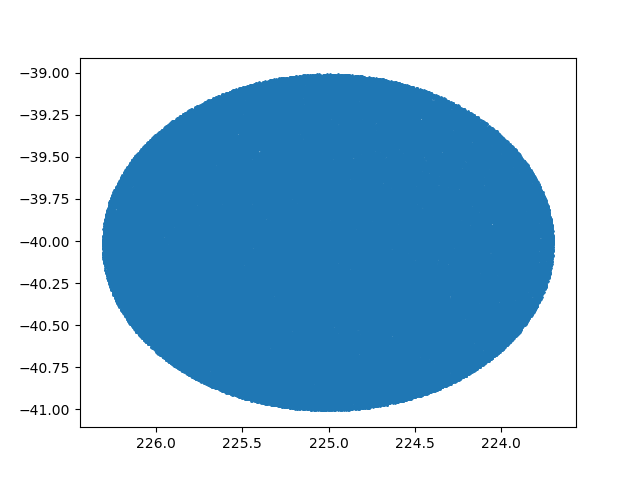

In [60]:
plt.figure()
plt.scatter(refCatSpatial['ra'], refCatSpatial['dec'], s=1)
plt.xlim(plt.xlim()[::-1])

# Transformation for sky to camera coordinates

In [61]:
from lsst.afw.cameraGeom import Camera

In [62]:
#help(Camera)

In [63]:
repo = '/sdf/group/rubin/repo/dc2_20210215'
collection = '2.2i/runs/DP0.1'

In [64]:
butler = dafButler.Butler(repo, collections=collection)
camera = butler.get('camera', instrument='LSSTCam-imSim')

In [65]:
#camera

In [66]:
#dir(camera)

In [67]:
import lsst.afw.geom as afwGeom
import lsst.afw.cameraGeom as cameraGeom

In [68]:
# https://lsstc.slack.com/archives/C2JPMCF5X/p1569266787124100
# https://community.lsst.org/t/constructing-a-wcs-from-camera-geometry/3039
def getWcsFromDetector(detector, boresight, rotation=0*lsst.geom.degrees, flipX=False):
    """Given a detector and (boresight, rotation), return that detector's WCS

    Parameters
    ----------
    detector : `lsst.afw.cameraGeom.Detector`
        A detector in a camera.
    boresight : `lsst.geom.SpherePoint`
       The boresight of the observation.
    rotation : `lsst.afw.geom.Angle`, optional
        The rotation angle of the camera.
        The rotation is "rotskypos", the angle of sky relative to camera
        coordinates (from North over East).
    flipX : `bool`, optional
        Flip the X axis?

    Returns
    -------
    wcs : `lsst::afw::geom::SkyWcs`
        The calculated WCS.
    """
    trans = detector.getTransform(detector.makeCameraSys(cameraGeom.PIXELS),
                                  detector.makeCameraSys(cameraGeom.FIELD_ANGLE))

    wcs = afwGeom.makeSkyWcs(trans, rotation, flipX, boresight)

    return wcs

In [69]:
def getDetectorId(refCatSpatial, camera, boresight, rotation, flipX=False):
    detId = np.zeros(len(refCatSpatial)) - 1.
    for det in camera:
        
        # Emulate ComCam by considering only the central raft
        if 'R22' not in det.getName():
            continue
            
        wcs = getWcsFromDetector(det, boresight, rotation=rotation, flipX=flipX)
        x, y = wcs.skyToPixelArray(refCatSpatial['ra'], refCatSpatial['dec'], degrees=True)
        
        # Detector
        selected = det.getBBox().contains(x, y)
        detId[selected] = det.getId()
        #print(det.getId(), det.getName(), np.sum(selected))
        
        # Focal Plane Coordinates
        #xy_fp = det.transform([lsst.geom.Point2D(x, y) for x, y in zip(x, y)], cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
        #x_fp, y_fp = zip(*[[_.x, _.y] for _ in xy_fp])

    #return detId, np.array(x_fp), np.array(y_fp)
    #return detId, x_fp, y_fp
    return detId

In [70]:
def getFpCoordinates(refCatSpatial, camera, boresight, rotation, flipX=False):
    # Emulate ComCam
    det = camera.get('R22_S11')
    wcs = getWcsFromDetector(det, boresight, rotation=rotation, flipX=flipX)
    x, y = wcs.skyToPixelArray(refCatSpatial['ra'], refCatSpatial['dec'], degrees=True)
    xy_fp = det.transform([lsst.geom.Point2D(x, y) for x, y in zip(x, y)], cameraGeom.PIXELS, cameraGeom.FOCAL_PLANE)
    x_fp, y_fp = zip(*[[_.x, _.y] for _ in xy_fp])
    return np.array(x_fp), np.array(y_fp)

## Test transform from sky to camera coordinates

In [71]:
boresight = lsst.geom.SpherePoint(180., -1., units=lsst.geom.degrees)
rotation = 45.*lsst.geom.degrees
flipX = False

In [72]:
#for det in camera:
#    center = det.getOrientation().getFpPosition()
#    print(center)

In [73]:
det = camera[0]

In [74]:
det.getName()

'R01_S00'

In [75]:
#dir(det)

In [76]:
trans = det.getTransform(det.makeCameraSys(cameraGeom.PIXELS), det.makeCameraSys(cameraGeom.FIELD_ANGLE))

In [77]:
wcs = afwGeom.makeSkyWcs(trans, rotation, flipX, boresight)

In [78]:
wcs

FITS standard SkyWcs:
Sky Origin: (180.0000000000, -1.0000000000)
Pixel Origin: (19033.5, 31599.5)
Pixel Scale: 0.2 arcsec/pixel

In [79]:
wcs = getWcsFromDetector(det, boresight, rotation=rotation, flipX=flipX)

In [80]:
help(wcs.skyToPixelArray)

Help on method skyToPixelArray in module lsst.afw.geom.skyWcs:

skyToPixelArray(ra, dec, degrees=False) method of lsst.afw.geom.SkyWcs instance
    Convert numpy array sky (ra, dec) positions to numpy array
    pixels (x, y).
    
    Parameters
    ----------
    ra : `np.ndarray`
        Array of Right Ascension.  Units are radians unless
        degrees=True.
    dec : `np.ndarray`
        Array of Declination.  Units are radians unless
        degrees=True.
    degrees : `bool`, optional
        Input ra, dec arrays are degrees if True.
    
    Returns
    -------
    x : `np.ndarray`
        Array of x values.
    y : `np.ndarray`
        Array of y values.



In [81]:
x, y = wcs.skyToPixelArray(refCatSpatial['ra'], refCatSpatial['dec'], degrees=True)

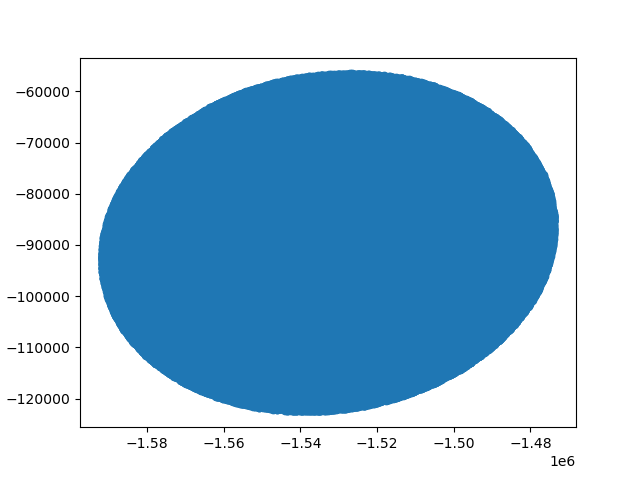

In [82]:
plt.figure()
plt.scatter(x, y)

In [83]:
selected = det.getBBox().contains(x, y)

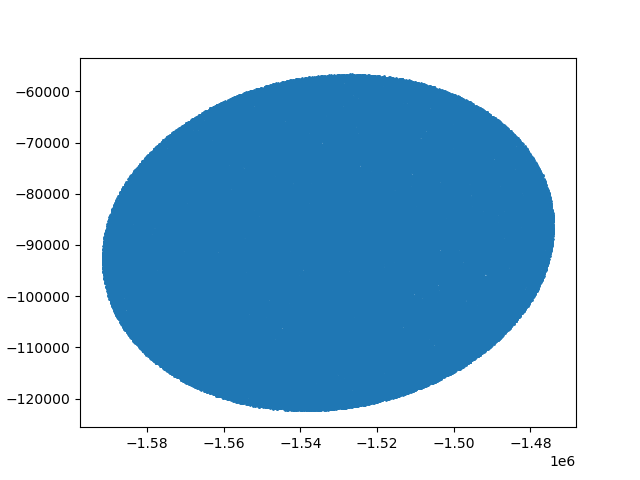

In [84]:
plt.figure()
plt.scatter(x[~selected], y[~selected], s=1)
plt.scatter(x[selected], y[selected], s=1)

In [85]:
det.getId()

0

In [86]:
#detId = np.empty(len(refCatSpatial)).fill(-1.)
detId = np.zeros(len(refCatSpatial)) - 1.
for det in camera:
    if 'R22' not in det.getName():
        continue
    wcs = getWcsFromDetector(det, boresight, rotation=rotation, flipX=flipX)
    x, y = wcs.skyToPixelArray(refCatSpatial['ra'], refCatSpatial['dec'], degrees=True)
    selected = det.getBBox().contains(x, y)
    detId[selected] = det.getId()
    print(det.getId(), det.getName(), np.sum(selected))

90 R22_S00 0
91 R22_S01 0
92 R22_S02 0
93 R22_S10 0
94 R22_S11 0
95 R22_S12 0
96 R22_S20 0
97 R22_S21 0
98 R22_S22 0


In [87]:
detId = getDetectorId(refCatSpatial, camera, boresight, rotation, flipX)
#detId, x_fp, y_fp = getDetectorId(refCatSpatial, camera, boresight, rotation, flipX)

In [88]:
x_fp, y_fp = getFpCoordinates(refCatSpatial, camera, boresight, rotation, flipX)

In [89]:
np.unique(detId)

array([-1.])

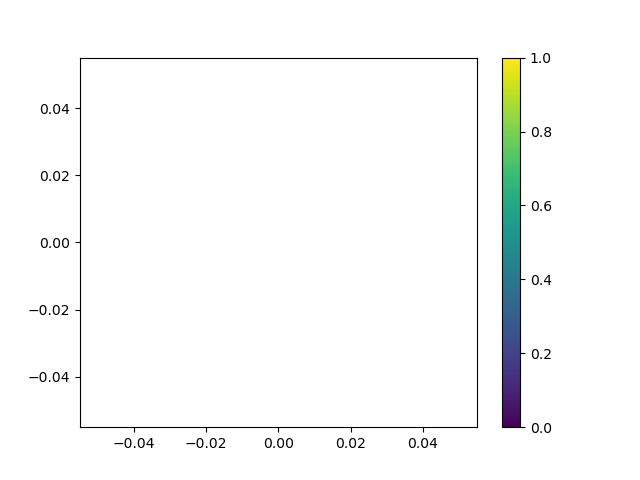

In [90]:
selected = (detId >= 0)

plt.figure()
plt.scatter(refCatSpatial['ra'][selected], refCatSpatial['dec'][selected], c=detId[selected], s=1)
plt.colorbar()

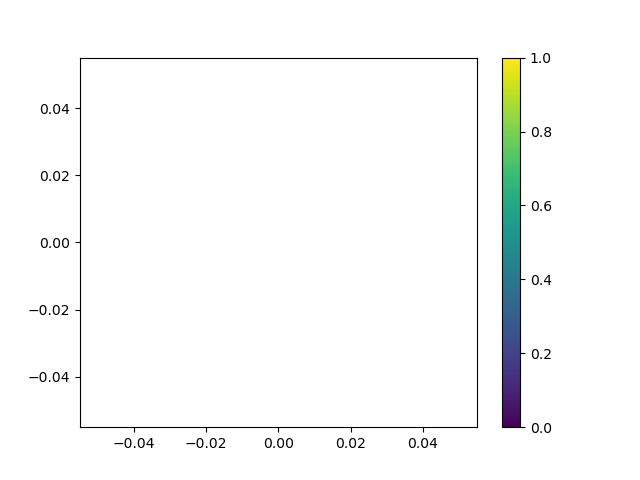

In [91]:
plt.figure()
plt.scatter(x_fp[selected], y_fp[selected], c=detId[selected], s=1)
plt.colorbar()

In [92]:
detId = np.zeros(len(refCatSpatial)) - 1
print(detId.shape)
print(detId)

(182819,)
[-1. -1. -1. ... -1. -1. -1.]


In [93]:
detId = np.empty(len(refCatSpatial))
print(detId.shape)
print(detId)

(182819,)
[ 4.66249103e-310  4.66249190e-310  4.66249103e-310 ... -1.00000000e+000
 -1.00000000e+000  7.22600651e-318]


# Set of dithers

In [94]:
# For testing
# n = 20
# ra_boresight_array = 180. + np.random.uniform(-0.2, 0.2, size=n)
# dec_boresight_array = -1. + np.random.uniform(-0.2, 0.2, size=n)
# rotation_array = np.random.uniform(-180., 180., size=n)

In [95]:
survey_name = 'Rubin_SV_225_-40'
filter = 'r'
nights_rehearsal = [night_first, night_first + 1, night_first + 2]
#nights_rehearsal = [night_first]

#selection = (observations['note'] == survey_name) & (observations['filter'] == filter) & (observations['night'] == night_first)
selection = (observations['target'] == survey_name) & (observations['filter'] == filter) & np.in1d(observations['night'], nights_rehearsal)
ra_boresight_array = observations['fieldRA'].values[selection]
dec_boresight_array = observations['fieldDec'].values[selection]
rotation_array = observations['rotSkyPos'].values[selection]

print(np.sum(selection))

200


In [96]:
# Subsample
ra_boresight_array = ra_boresight_array[::6]
dec_boresight_array = dec_boresight_array[::6]
rotation_array = rotation_array[::6]

print(len(ra_boresight_array))

34


Text(0.5, 0.98, 'Telescope Boresight Pointings and Camera Rotation Angles')

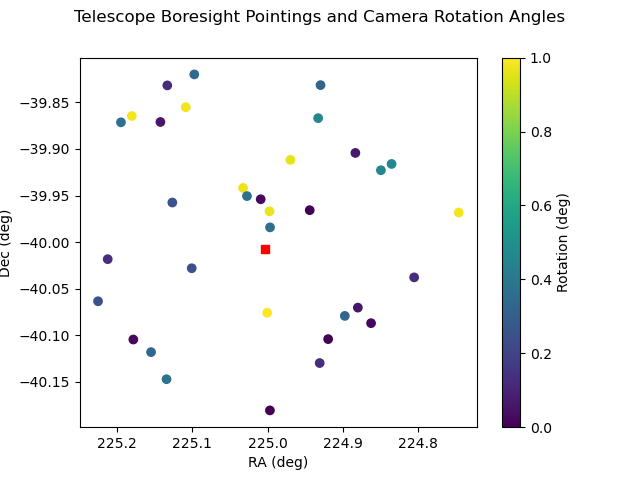

In [97]:
plt.figure()
plt.scatter(ra_boresight_array, dec_boresight_array, c=rotation_array)
plt.scatter(ra_center, dec_center, c='red', marker='s')
plt.colorbar(label='Rotation (deg)')
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.suptitle('Telescope Boresight Pointings and Camera Rotation Angles')

In [98]:
n = 30
detId_array = []
x_fp_array = []
y_fp_array = []
for visit_index in range(0, n):
    print(visit_index)
    boresight_visit = lsst.geom.SpherePoint(ra_boresight_array[visit_index], dec_boresight_array[visit_index], units=lsst.geom.degrees)
    rotation_visit = rotation_array[visit_index]*lsst.geom.degrees
    detId = getDetectorId(refCatSpatial, camera, boresight_visit, rotation_visit)
    detId_array.append(detId)
    x_fp, y_fp = getFpCoordinates(refCatSpatial, camera, boresight_visit, rotation_visit)
    x_fp_array.append(x_fp)
    y_fp_array.append(y_fp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [99]:
detId_array = np.array(detId_array)
x_fp_array = np.array(x_fp_array)
y_fp_array = np.array(y_fp_array)

In [100]:
detId_array.shape

(30, 182819)

In [101]:
counts = np.sum(detId_array >= 0, axis=0)

/tmp/ipykernel_9155/2313187234.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Text(0, 0.5, 'Dec (deg)')

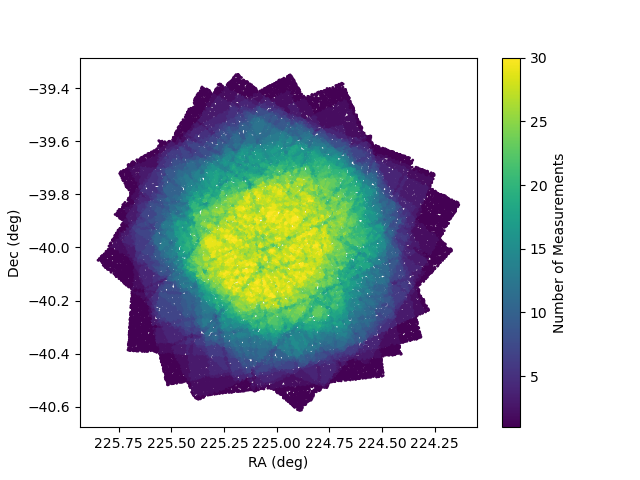

In [102]:
selected = (counts > 0)
plt.figure()
plt.scatter(refCatSpatial['ra'][selected], refCatSpatial['dec'][selected], c=counts[selected], s=1)
plt.colorbar(label='Number of Measurements')
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

Text(0, 0.5, 'Number of Measurements')

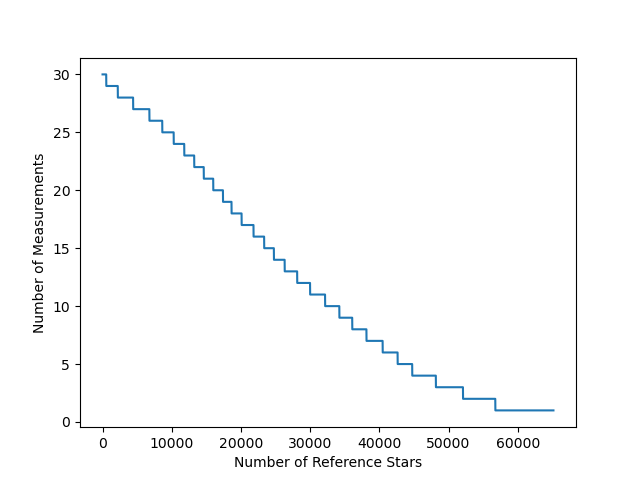

In [103]:
plt.figure()
plt.plot(np.sort(counts[selected])[::-1])
plt.xlabel('Number of Reference Stars')
plt.ylabel('Number of Measurements')

In [104]:
# Number of unique detectors that each star appeared on

In [105]:
unique_det = np.array([len(np.unique(_[_ >= 0])) for _ in detId_array.T])

Text(0, 0.5, 'Dec (deg)')

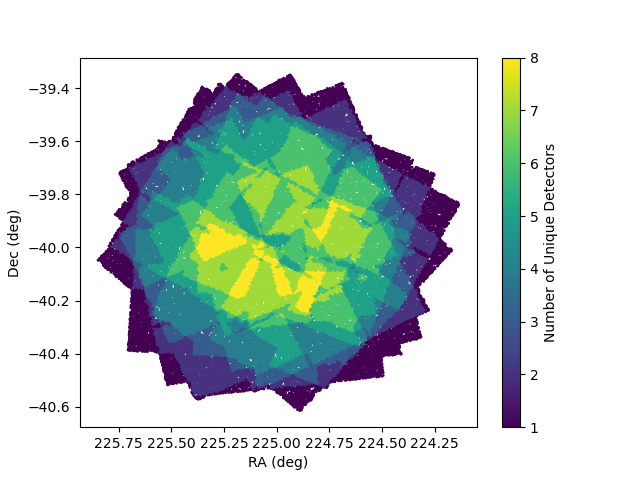

In [106]:
selected = (counts >= 1)
plt.figure()
plt.scatter(refCatSpatial['ra'][selected], refCatSpatial['dec'][selected], c=unique_det[selected], s=1)
plt.colorbar(label='Number of Unique Detectors')
plt.xlim(plt.xlim()[::-1])
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')

Text(0, 0.5, 'Number of Unique Detectors')

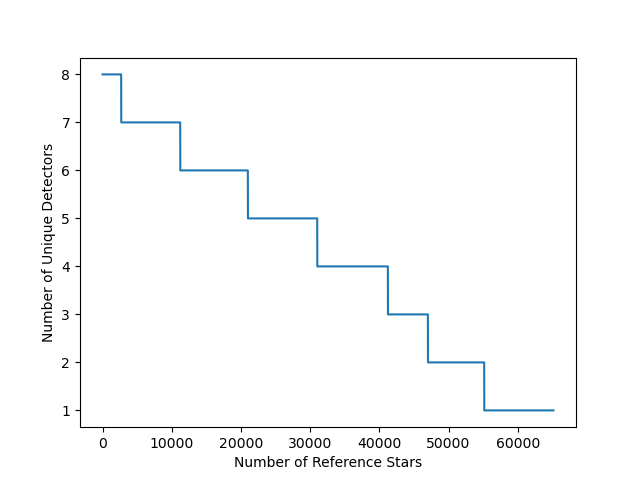

In [107]:
plt.figure()
plt.plot(np.sort(unique_det[selected])[::-1])
plt.xlabel('Number of Reference Stars')
plt.ylabel('Number of Unique Detectors')

In [108]:
# Number of repeated visits in focal plane coordinates
# Need to define some minimum number of measurements per star

In [109]:
counts_array = np.tile(counts, detId_array.shape[0]).reshape(detId_array.shape)
unique_det_array = np.tile(unique_det, detId_array.shape[0]).reshape(detId_array.shape)

Text(0, 0.5, 'Focal Plane y (mm)')

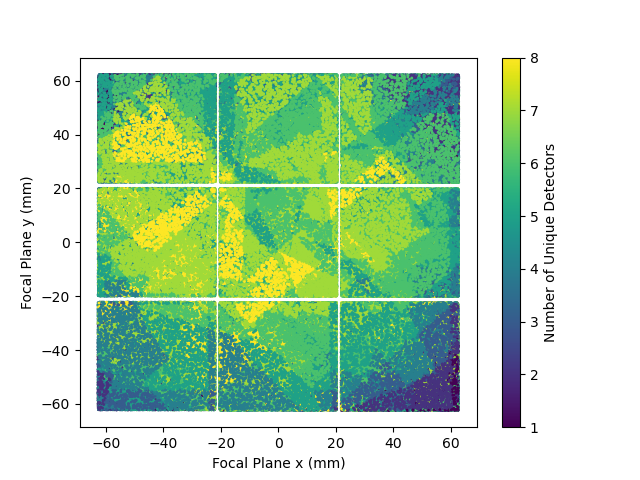

In [110]:
plt.figure()
plt.scatter(x_fp_array[detId_array >= 0], y_fp_array[detId_array >= 0], c=unique_det_array[detId_array >= 0], s=1)
plt.colorbar(label='Number of Unique Detectors')
plt.xlabel('Focal Plane x (mm)')
plt.ylabel('Focal Plane y (mm)')

Text(0, 0.5, 'Focal Plane y (mm)')

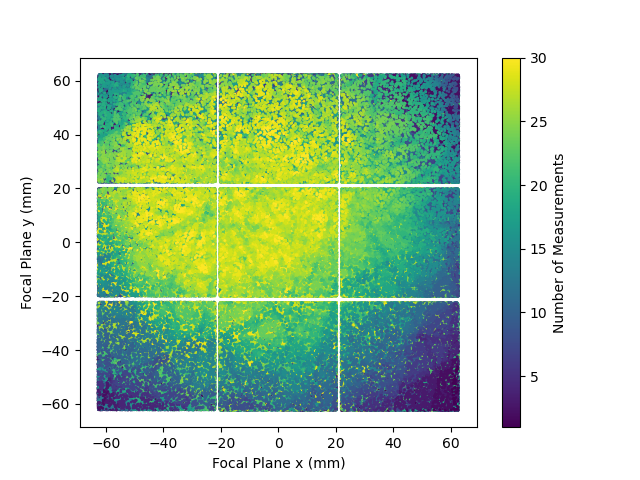

In [111]:
plt.figure()
plt.scatter(x_fp_array[detId_array >= 0], y_fp_array[detId_array >= 0], c=counts_array[detId_array >= 0], s=1)
plt.colorbar(label='Number of Measurements')
plt.xlabel('Focal Plane x (mm)')
plt.ylabel('Focal Plane y (mm)')